## Cluster Finder

A quick, visual way to spot clusters in Gaia DR2 data, using distance, proper motion, and error cuts!

Instructions: Get Gaia DR2 Vizier data by querying Gaia DR2, typing in some object or coordiantes, picking a search radius (I like 2 deg), deselecting all parameters, selecting Plx, e_Plx, pmRA, e_pmRA, pmDE, e_pmDE, Gmag, e_Gmag, BPmag, e_BPmag, RPmag, e_RPmag, RV, and e_RV, and outputting unlimited values as tab separated values file type. If you know the approximate distance range to your target range, you are encouraged to enter a rough, somewhat generous parallax range into Vizier, as this will greatly cut down on the perhaps irrelevant targets and make the data file way more manageable. The .tsv file should show up in your downloads folder (specify path in Setup below). Place Padova isochrones files PadovaGaiaDR2Isochrones.dat in data folder (also specify path in Setup below). Trim the file with viztrim function. Explore distance, proper motion, and error cuts with plotcut function until you see a bunch of stars of one color in distance, proper motion in RA, and proper motion in Dec. Produce a data file and final plot with finalcut function. Plot Gaia DR2 BP-RP color-magnitude diagram of the stars. Note that dim scattered points near bottom are probably garbage. Happy hunting!

If you use this code and find it helpful, please cite Yep & White 2019, in prep.

## Setup

In [13]:
#import Python stuff
import numpy as np
import math
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18,'lines.linewidth':4})
import matplotlib.cm as cm
from os.path import exists

#Your directories:
downdir='/Users/Cougy/Downloads/' #downloads folder, where Vizier will put the .tsv
ddir='/Users/Cougy/gsu-thesis/Research/PythonPlots/data/' #where to access and save your data
pdir='/Users/Cougy/gsu-thesis/Research/PythonPlots/plots/' #where to save your plots

#error-weighted mean
def erm(val,err): #list,list
    v=np.array(val)
    e=np.array(err)
    w=1.0/e**2.0
    avg=sum(w*val)/sum(w)
    avgerr=1.0/np.sqrt(sum(w))
    return avg,avgerr

def viztrim(vizfilename,objname): #'vizier filename','object name'; expects filen of type .tsv in downloads folder; saves file in ddir as 'gaiasearch_objname.dat'
    f=open(downdir+vizfilename+'.tsv','r')       #objname could alternatively be a location name, e.g. coordinates.
    dat=f.readlines()                     #only have to run this once for each data set, just to generate nicely formatted data file without doing any work. :P
    f.close()                             #comment out viztrim stuff when you're done, to avoid rewriting your data files! Probably can prevent rewriting gaiasearch_etc, have to say 'y' or something.
    dt=[a[:2] for a in dat]
    
    labind=dt.index('_r')
    try:
        datend=dt[int(2./3.*len(dt)):].index('#N')+int(2./3.*len(dt))-2 #assumes data set is reasonably long. If not, you can replace 2./3. with, say, 1./2. or less.
    except ValueError:
        datend=len(dt)-1
    print (labind,datend,'\n')
    pind=list(range(labind,labind+4))+list(range(datend-1,datend))
    for i in pind: #just to check it's right
        print (dat[i][:-1]) #just to check it's right)
        if i == labind+3 :
            print ('...')
    print('---end---')

    if exists(ddir+'gaiasearch_'+objname+'.dat'):
        rewri=input("You've already trimmed Vizier Gaia DR2 data for this object name. Rewrite? 'y'/'n'\n")
        if rewri=='y':
            with open(ddir+'gaiasearch_'+objname+'.dat', 'w') as f:
                #print>>f,'#'+dat[labind][:-1]
                print('#'+dat[labind][:-1], file=f)
                for d in dat[labind+3:datend]:
                    #print>>f, '\t'.join(d[:-1].split('\t')) #to keep tabs and get rid of extra line break
                    print('\t'.join(d[:-1].split('\t')), file=f)
                f.close()
            print ('File rewritten.')
        else:
            print ('File NOT rewritten.')
    else:
        #f=open(ddir+'gaiasearch_'+objname+'.dat','w')
        with open(ddir+'gaiasearch_'+objname+'.dat', 'w') as f:
            #print>>f,'#'+dat[labind][:-1]
            print('#'+dat[labind][:-1], file=f)
            for d in dat[labind+3:datend]:
                #print>>f, '\t'.join(d[:-1].split('\t')) #to keep tabs and get rid of extra line break
                print('\t'.join(d[:-1].split('\t')), file=f)
            f.close()

#open Gaia DR2 file, pt. 1
def opendatg(objname): #'filename'. For opening a data file in ddir.
    f=open(ddir+'gaiasearch_'+objname+'.dat','r')
    dat=f.readlines()
    f.close()
    labels=dat[0][0:-1].split()
    dat2=[[a.strip('\n') for a in d.split('\t')] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

#open Gaia DR2 file, pt. 2
def opendat2g(objname,params): #Use as var,var,var...=opendat2(dir,'filename',['keys']).
    dat,label=opendatg(objname)  #Get keys by first leaving ['keys'] blank: opendat2(objname,[])
    print (label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    return varrs

#Regular opendat that I use:
def opendat(dir,filename): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    labels=dat[0][0:-1].split()
    dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]
def opendat2(dirr,filename,params): #Use as var,var,var...=opendat2(dir,'filename',['keys']).
    dat,label=opendat(dirr,filename)  #Get keys by first leaving ['keys'] blank: opendat2(dirr,filename,[])
    print (label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    return varrs

#Exploratory Cuts
#Doesn't save anything, just lets you look around. Do so until you're happy and then shove parameters into Final Cut. :)
#Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode
def plotcut(objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,Color): #colorcode by Color param: 'dist', 'pra', 'pdec'    
    print ("input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode\n")
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr=opendat2g(objname,('_RAJ2000', '_DEJ2000','Plx', 'e_Plx','pmRA', 'e_pmRA', 'pmDE', 'e_pmDE','Gmag', 'e_Gmag','BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV'))
    print ('original length:',len(p))
    
    pmin,pmax=1000./dmax,1000./dmin
    pars=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr]
    PARS=[]
    for par in pars:
        PAR=[par[i] for i in range(len(p)) if p[i]<pmax and p[i]>pmin and pra[i]<pramax and pra[i]>pramin and pdec[i]<pdecmax and pdec[i]>pdecmin and perr[i]<perrmax and praerr[i]<pmerrmax and pdecerr[i]<pmerrmax]
        PARS.append(PAR)
    #return PARS
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr=PARS
    print ('Cut length:',len(p))
    
    if Color=='dist':
        D,clab=1000./np.array(p),'$d$ (pc)' #distance
    if Color=='pra':
        D,clab=pra,'$\mu_{\\alpha}$ (mas/yr)' #pra
    if Color=='pdec':
        D,clab=pdec,'$\mu_{\delta}$ (mas/yr)' #pdec
    
    cmin=np.nanmin(D)
    cmax=np.nanmax(D) #capping it here for colorcoding
    precvrs=[(c-cmin)/(cmax-cmin) for c in D]
    CC=[plt.cm.rainbow(v) for v in precvrs]

    plt.figure(figsize=(10,10))
    plt.title(objname.upper()+' Region')
    plt.scatter(ra,dec,color=CC)
    plt.xlim(np.max(ra)+0.1,np.min(ra)-0.1)
    plt.ylim(np.min(dec)-0.1,np.max(dec)+0.1)
    plt.ylabel('Dec ($^{\circ}$)')
    plt.xlabel('RA ($^{\circ}$)')    #plt.xlim(121,125)
    #plt.ylim(-35,-37)
    colors = plt.cm.rainbow(D)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=cmin, vmax=cmax))
    # fake up the array of the scalar mappable. Urgh…
    sm._A = []
    cbar=plt.colorbar(sm,pad=0.01)
    cbar.set_label(label=clab)
    return (objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax)

#Final Cut
#Exports data file. You can add to plot as necessary. When you like it, you can save it.
#plt.legend(fontsize=10,scatterpoints=1,loc=4)
#plt.savefig(pdir+'gaiacands_'+objname+'_l'+str(magmax)+'.png')
#pars output from plotcut,RA Dec window,brighter-than-mag to mark]

def finalcut(pars,ramin,ramax,decmin,decmax,magmax): #box cut, from refining plotcut above. Save fig at end, after adding any extras like legend() and ref stars.
    print ("input: pars output from plotcut,RA Dec window,brighter-than-mag to mark\n")
    objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax=pars
    
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr=opendat2g(objname,('_RAJ2000', '_DEJ2000','Plx', 'e_Plx','pmRA', 'e_pmRA', 'pmDE', 'e_pmDE','Gmag', 'e_Gmag','BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV'))
    print ('original length:',len(p))
    
    pmin,pmax=1000./dmax,1000./dmin
    pars=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr]
    PARS=[]
    for par in pars:
        PAR=[par[i] for i in range(len(p)) if p[i]<pmax and p[i]>pmin and pra[i]<pramax and pra[i]>pramin and pdec[i]<pdecmax and pdec[i]>pdecmin and ra[i]<ramax and ra[i]>ramin and dec[i]<decmax and dec[i]>decmin]
        PARS.append(PAR)
    #return PARS
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr=PARS
    print ('Cut length:',len(p))
    
    lab=('#ra', 'dec','p', 'perr','pra', 'praerr', 'pdec', 'pdecerr','G', 'Gerr','BP','BPerr','RP','RPerr','rv','rverr')
    ds=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr]
    dsp=[[str(d[i]) for d in ds] for i in range(len(ra))]

    #f=open(ddir+'gaiacands_'+objname.upper()+'.dat','w')
    with open(ddir+'gaiacands_'+objname.upper()+'.dat','w') as f:
        print(' \t '.join(lab), file=f)
    #print>>f, ' \t '.join(lab)
        for d in dsp:
            print(' \t '.join(d), file=f)
            #print>>f, ' \t '.join(d)
        f.close()
    
    print ('\nSaved data to '+ddir+'gaiacands_'+objname.upper()+'.dat.\n')
    
    print ('G mag:',np.min(G),'-',np.max(G),', straight mean',np.mean(G))
    print ('Stars brighter than mag %s:' %magmax,len(np.array(G)[np.array(G)<magmax]),'\n')

    mask=np.array(G)<magmax

    PARS=plotcut(objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,'dist')
    plt.scatter(np.array(ra)[mask],np.array(dec)[mask],facecolor='None',marker='*',edgecolor='black',linewidth=0.6,s=200,label='New Targets G < '+str(magmax))
    plt.ylim(decmin,decmax)
    plt.xlim(ramax,ramin)
    plt.legend(fontsize=10,scatterpoints=1)
    #plt.savefig(pdir+objname+'_gaiacands_l'+str(magmax)+'.png')
    
    #toggle to save just G<10 data for easy CHIRON objects
    '''
    mask10=np.array(G)<10
    lab10=('#ra', 'dec','p', 'perr','pra', 'praerr', 'pdec', 'pdecerr','G', 'Gerr','BP','BPerr','RP','RPerr','rv','rverr')
    ds10=[np.array(ra)[mask10],np.array(dec)[mask10],np.array(p)[mask10],np.array(perr)[mask10],np.array(pra)[mask10],np.array(praerr)[mask10],np.array(pdec)[mask10],np.array(pdecerr)[mask10],np.array(G)[mask10],np.array(Gerr)[mask10],np.array(B)[mask10],np.array(Berr)[mask10],np.array(R)[mask10],np.array(Rerr)[mask10],np.array(rv)[mask10],np.array(rverr)[mask10]]
    dsp10=[[str(d[i]) for d in ds10] for i in range(len(np.array(ra)[mask10]))]    
    with open(ddir+'gaiacands_'+objname.upper()+'_l10.dat','w') as f:
        print(' \t '.join(lab10), file=f)
    #print>>f, ' \t '.join(lab10)
        for d in dsp10:
            print(' \t '.join(d), file=f)
            #print>>f, ' \t '.join(d)
        f.close()
    '''

tmodp,Gmodp,Bmodp,Rmodp=opendat2(ddir,'PadovaGaiaDR2Isochrones.dat',('Age','Gmag','G_BPmag','G_RPmag'))

#Color-Magnitude Diagaram
#Plot a rough Gaia BP-RP vs. BP color-magnitude diagram of your stars, with reference to Padova Gaia DR2 isochrones. Garrett Somers' are WAY better, but they're not published yet!
def colmagBR(objname,dist):
    print ('input: Object name, average distance to potential cluster, save plot y or n')
    p,perr,G,Gerr,B,Berr,R,Rerr=opendat2(ddir,'gaiacands_'+objname+'.dat',('p', 'perr','G', 'Gerr','BP','BPerr','RP','RPerr')) #maybe add add-nan capability for blank slots!

    t4myr=(np.array(tmodp)==3.98e6)
    t1gyr=(np.array(tmodp)==1.0e9)

    plt.figure(figsize=(10,6))
    
    #Padova:
    plt.plot((Bmodp-Rmodp)[t1gyr][:-10],Bmodp[t1gyr][:-10]-2.5*np.log10(100./(dist**2.)),label='1 Gyr')
    plt.plot((Bmodp-Rmodp)[t4myr][:-40],Bmodp[t4myr][:-40]-2.5*np.log10(100./(dist**2.)),label='1 Myr')

    #plt.plot(((np.array(B)-np.array(R))[1],R[20]),alpha=0.0,label=str(dist)+' pc')
    
    plt.scatter(np.array(B)-np.array(R),B)
    plt.xlabel('BP-RP')
    plt.ylabel('BP')

    #plt.xlim(-15,10)
    plt.ylim(np.nanmax(B)+0.3,np.nanmin(B)-0.3)
    plt.legend(fontsize=12)
    
    #plt.savefig(ddir+'gaiacolormag_'+objname+'.png')

['#Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag']


## Sample

Files: Place asu_CG30.tsv, in default Downloads folder (I use a Mac). Place PadovaGaiaDR2Isochrones in chosen data folder.

In [14]:
viztrim('asu_CG30','CG30test')

81 24408 

_r	_RAJ2000	_DEJ2000	Plx	e_Plx	pmRA	e_pmRA	pmDE	e_pmDE	Gmag	e_Gmag	BPmag	e_BPmag	RPmag	e_RPmag	RV	e_RV
deg	deg	deg	mas	mas	mas/yr	mas/yr	mas/yr	mas/yr	mag	mag	mag	mag	mag	mag	km/s	km/s
--------	-----------------	-----------------	----------	-------	---------	------	---------	------	-------	------	-------	------	-------	------	-------	-----
1.994350	119.9191030945716	-36.1430281125800	    3.4127	 1.1366	   -3.554	 1.942	   -6.309	 1.997	20.5252	0.0094	20.9728	0.1371	19.1837	0.0379	       	
...
1.999239	124.8604969676085	-36.1372022614895	    3.9742	 0.0828	   16.392	 0.140	   -1.973	 0.136	17.5027	0.0010	18.8513	0.0191	16.3224	0.0072	       	

#Table	I_345_rvstdcat:
#Name: I/345/rvstdcat
You've already trimmed Vizier Gaia DR2 data for this object name. Rewrite? 'y'/'n'
'y'
File rewritten.


input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode

['#_r', '_RAJ2000', '_DEJ2000', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV']
original length: 24324
Cut length: 27


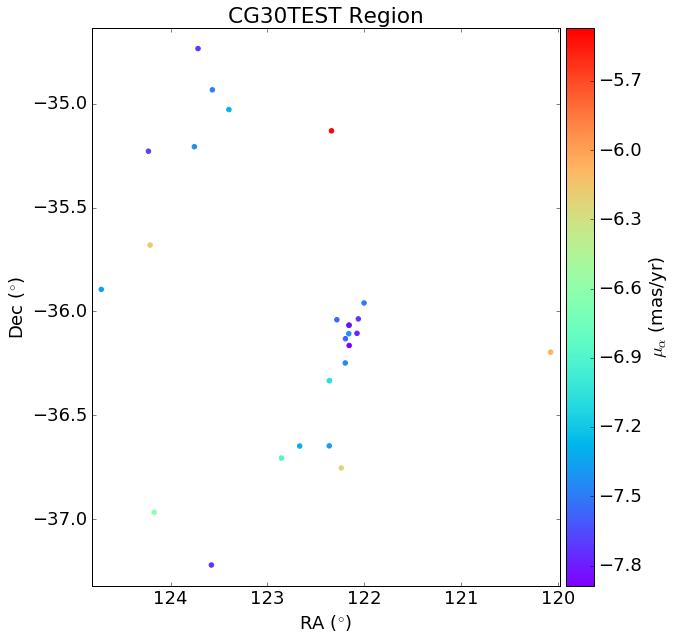

In [15]:
CG30pars=plotcut('CG30test',340.,390.,-8.5,-5.,9.5,12.5,0.1,0.16,'pra') #using median errors for G mag 17 as detailed in Appendix C of Lindegren et al. 2018

input: pars output from plotcut,RA Dec window,brighter-than-mag to mark

['#_r', '_RAJ2000', '_DEJ2000', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV']
original length: 24324
Cut length: 27

Saved data to /Users/Cougy/gsu-thesis/Research/PythonPlots/data/gaiacands_CG30TEST.dat.

G mag: 12.6049 - 20.4682 , straight mean 16.6079888889
Stars brighter than mag 15: 6 

input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode

['#_r', '_RAJ2000', '_DEJ2000', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV']
original length: 24324
Cut length: 27


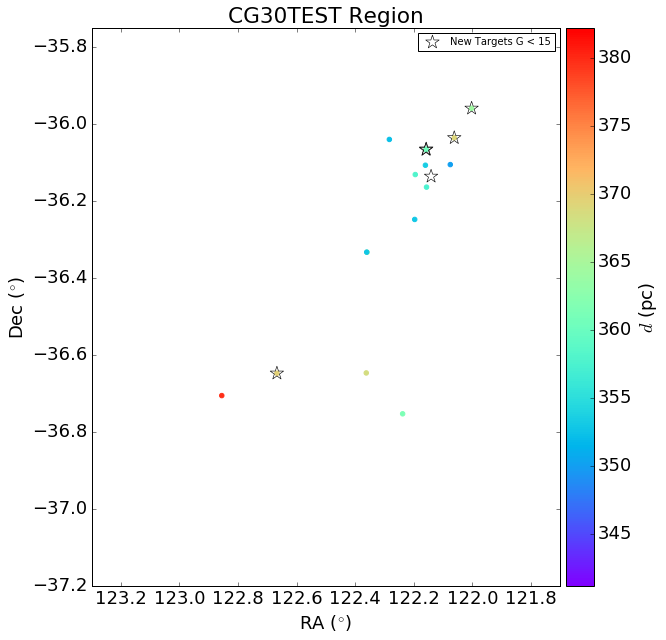

In [16]:
finalcut(CG30pars,121.7,123.3,-37.2,-35.75,15)

input: Object name, average distance to potential cluster, save plot y or n
['#ra', 'dec', 'p', 'perr', 'pra', 'praerr', 'pdec', 'pdecerr', 'G', 'Gerr', 'BP', 'BPerr', 'RP', 'RPerr', 'rv', 'rverr']


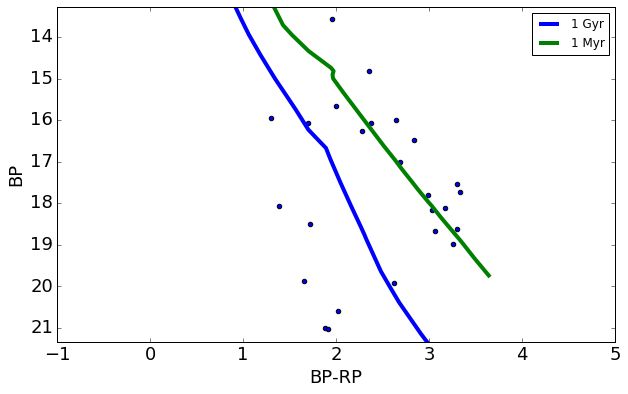

In [17]:
colmagBR('CG30TEST',361.8)